In [1]:
import json
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import clip
from transformers import CLIPProcessor, CLIPModel
import os
from tqdm import tqdm
import torch.nn.functional as F

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

In [5]:
class image_caption_dataset(Dataset):
    def __init__(self, image_paths, image_captions, preprocess):
        self.image_paths = image_paths
        self.image_captions = clip.tokenize(image_captions)
        self.preprocess = preprocess

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = preprocess(Image.open(self.image_paths[idx]))
        caption = self.image_captions[idx]
        return image, caption

In [4]:
with open("descriptions.json") as f:
    descriptions = json.load(f)

image_captions = []
image_paths = []
for description in descriptions:
    path = f"/scratch/sanika/wikiart/{description['filename']}"
    image_captions.append(description["description"])
    image_paths.append(path)

In [ ]:
dataset = image_caption_dataset(image_paths, image_captions, preprocess)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
def convert_to_fp32(model): 
    for p in model.parameters(): 
        p.data = p.data.float() 
        p.grad.data = p.grad.data.float() 

In [8]:
# load weghts
model.load_state_dict(torch.load("model_4.pt"))

<All keys matched successfully>

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=4e-5,betas=(0.9,0.98),eps=1e-5)
loss_image = nn.CrossEntropyLoss()
loss_caption = nn.CrossEntropyLoss()

In [ ]:
epochs = 5

for epoch in range(epochs):
    loss = 0
    for batch in tqdm(dataloader):
        optimizer.zero_grad()
        images, captions = batch
        images = images.to(device)
        captions = captions.to(device)

        logits_per_image, logits_per_text = model(images, captions)

        ground = torch.arange(len(images), dtype=torch.long).to(device)
        total_loss = loss_image(logits_per_image, ground) + loss_caption(logits_per_text, ground)
        total_loss.backward()
        convert_to_fp32(model)
        optimizer.step() 
        clip.model.convert_weights(model)
        loss += total_loss.item()

    # save model as epoch
    torch.save(model.state_dict(), f"model_{epoch}.pt")

    print("Epoch: {} Loss: {}".format(epoch, loss))

In [7]:
model.load_state_dict(torch.load("model_4.pt"))

<All keys matched successfully>

In [8]:
# save encodings of all the images
encodings = []
for image in tqdm(image_paths):
    img = preprocess(Image.open(image)).unsqueeze(0).to(device)
    with torch.no_grad():
        encodings.append(model.encode_image(img))

100%|██████████| 103250/103250 [20:04<00:00, 85.75it/s]


In [9]:
# save to file
torch.save(encodings, "encodings.pt")

In [5]:
encodings = torch.load("encodings.pt")

In [6]:
model, preprocess = clip.load("ViT-B/32", device=device)

In [7]:
model.load_state_dict(torch.load("model_9.pt"))

<All keys matched successfully>

In [8]:
# stack encodings
encodings = torch.stack(encodings)

In [17]:
print(encodings.shape)

torch.Size([103250, 1, 512])


In [9]:
encodings = encodings.squeeze(1)

In [10]:
# get input text, compare it with all the encodings, return top 5 images
def get_top_5_images(text):
    text_features = model.encode_text(clip.tokenize([text]).to(device))
    similarities = F.cosine_similarity(encodings, text_features, dim=-1)
    print(similarities.shape)
    # Get top 5 indices
    values, indices = similarities.topk(5)

    # Get top 5 image paths
    return [image_paths[i] for i in indices]

torch.Size([103250])


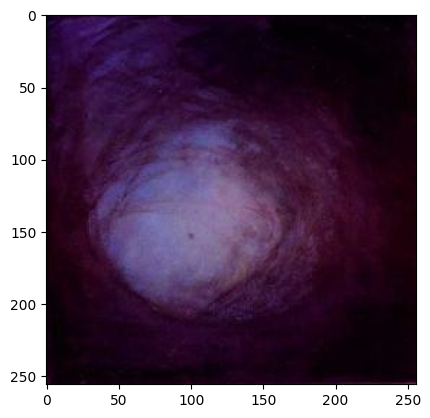

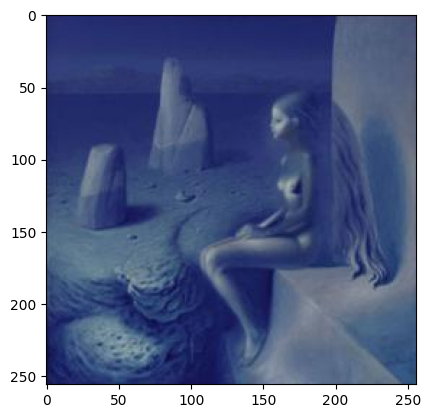

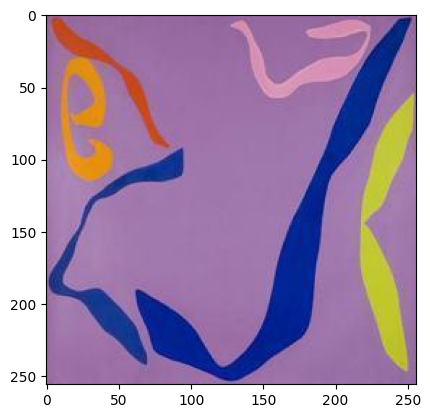

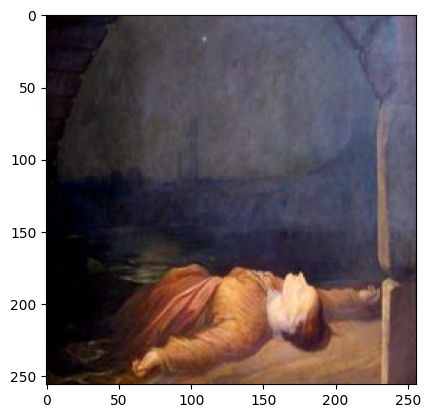

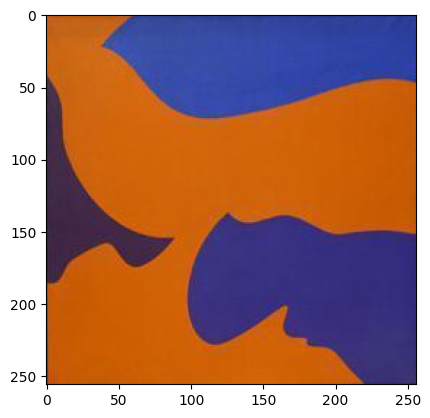

In [25]:
# load and plot images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

images = get_top_5_images("dark blue and realism")
for image in images:
    img = mpimg.imread(image)
    imgplot = plt.imshow(img)
    plt.show()

In [15]:
print(images)

['/scratch/sanika/wikiart/75458.jpg', '/scratch/sanika/wikiart/57460.jpg', '/scratch/sanika/wikiart/89092.jpg', '/scratch/sanika/wikiart/14701.jpg', '/scratch/sanika/wikiart/4581.jpg']
